# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P", "ENG"]
    drop_cols = []
    for i in cols:
        drop_first = f'{i}_{df_processed[i].value_counts().idxmax()}'
        drop_cols.append(drop_first)
        df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=[i]).drop(columns=drop_first)
    # df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    # df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex, drop_cols

data, data_original, target, group, drop_cols = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

# Task 1: 

In [2]:
drop_cols

['HINS1_1',
 'HINS2_2',
 'HINS4_2',
 'CIT_1',
 'COW_1.0',
 'SCHL_21.0',
 'MAR_1',
 'SEX_1',
 'RAC1P_1',
 'ENG_1.0']

In [3]:
# Using Random Forest to Classify if target is above income threshold

# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
X_train.head()

,AGEP,HINS1_2,HINS2_1,HINS4_1,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,...,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0
358945,46,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,False
275788,45,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
141517,40,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
66729,59,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
268579,23,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Accuracy:  0.771778294534025
              precision    recall  f1-score   support

       False       0.80      0.66      0.72     17488
        True       0.76      0.87      0.81     21645

    accuracy                           0.77     39133
   macro avg       0.78      0.76      0.76     39133
weighted avg       0.78      0.77      0.77     39133

Confusion Matrix: 
 [[11457  6031]
 [ 2900 18745]]


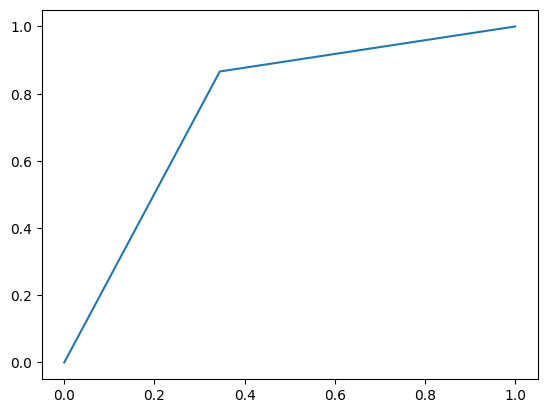

In [5]:
# Create example pipeline for task and report accuracy
args = {
    'n_estimators': 100,
    'max_depth' : 10,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
}
clf = RandomForestClassifier(**args)
pipeline = make_pipeline(clf)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# show roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

### Summary of necessary changes (to be put in report!)
The accuracy of the classifier sits at 0.77 as of baseline test with the selected pipeline. Standard-scaling was used across all features, which may end up causing trouble. The model has a fairly high accuracy for a baseline classifier, with desirable f1-scores at [0.72, 0.81]. Since the outcome variable in this case is almost equally balanced at the chosen threshold, we need not to scale our model much with respect to the outcome variable. In this pipeline discrete variables are scaled, which changes the otherwise explainable binary variables, which hurts the explainability of the model. <br>
<br>
We would need to only scale the age column in the data to fix this explainability issue. Unless we had more continuous ways of representing the discrete variables in the data (such as language test scores for english proficiency, SAT scores for education etc.) we would not be able to quantify these columns in any meaningful fashion.

In [6]:
# Modify pipeline to fulfill one of the fairness criteria (e.g. statistical parity, equal opportunity, etc.)
X_test = X_test.reset_index(drop=True)
s2 = X_test.query("SEX_2 == True")
s1 = X_test.query("SEX_2 == False")

true_s1 = []
for i in s1.index:
    true_s1.append(y_test[i])
true_s2 = []
for i in s2.index:
    true_s2.append(y_test[i])

probs_s2 = pipeline.predict_proba(s2)
probs_s1 = pipeline.predict_proba(s1)
preds_s1 = probs_s1[:,1] > 0.5
preds_s2 = probs_s2[:,1] > 0.5


# Compare outcomes across groups
print("Accuracy for group 1: ", accuracy_score(true_s1, preds_s1))
print("Accuracy for group 2: ", accuracy_score(true_s2, preds_s2))
fpr1, tpr1, thresholds1 = roc_curve(true_s1, probs_s1[:,1])
fpr2, tpr2, thresholds2 = roc_curve(true_s2, probs_s2[:,1])

print('Selection rate for s1: ', np.sum(preds_s1)/len(preds_s1))
print('Selection rate for s2: ', np.sum(preds_s2)/len(preds_s2))

Accuracy for group 1:  0.7915716987536977
Accuracy for group 2:  0.7497299049265341
Selection rate for s1:  0.6592308811405848
Selection rate for s2:  0.6040406222990493


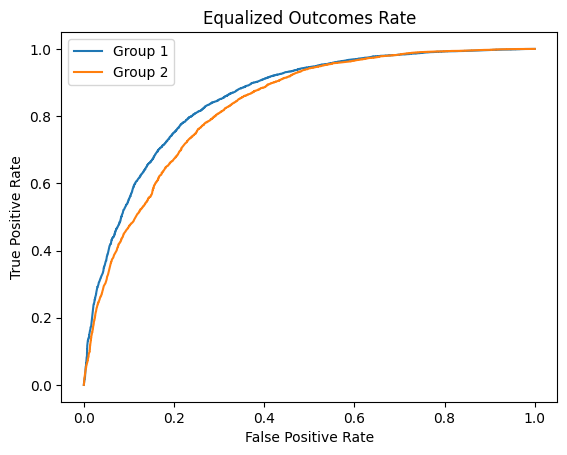

In [7]:
plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Equalized Outcomes Rate')
plt.legend()
plt.show()

In [8]:
# filename = '../models/random_forest.sav'
# pickle.dump(clf1, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, y_test)